In [1]:
import tensorboard

In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow
from keras.callbacks import TensorBoard
from tensorflow.keras.metrics import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import src.data.Dataset as dt

In [3]:
required_paths = ["/ai4eutils", "/CameraTraps", "/yolov5"]
python_path = os.environ.get("PYTHONPATH", "")
root_path = os.getcwd()

for path in required_paths:
    if not any(p.endswith(path) for p in python_path.split(":")):
        python_path += f":{root_path}/data/external{path}"

os.environ["PYTHONPATH"] = python_path

!echo "PYTHONPATH: $PYTHONPATH"

PYTHONPATH: :/Users/carlos/WORKSPACE/MegaClassifier/data/external/ai4eutils:/Users/carlos/WORKSPACE/MegaClassifier/data/external/CameraTraps:/Users/carlos/WORKSPACE/MegaClassifier/data/external/yolov5


In [4]:
IMAGES_DATASET_PATH = os.path.abspath("./data/raw/emptyNonEmptyDataset_ETL")

TRAIN_SAMPLES_CSV = os.path.abspath(
    "./data/raw/emptyNonEmptyDataset_ETL/28570Train.csv"
)
VALIDATION_SAMPLES_CSV = os.path.abspath(
    "./data/raw/emptyNonEmptyDataset_ETL/28570Validation.csv"
)
TEST_SAMPLES_CSV = os.path.abspath("./data/raw/emptyNonEmptyDataset_ETL/28570Test.csv")

print(f"IMAGES_DATASET_PATH:    {IMAGES_DATASET_PATH}")
print(f"TRAIN_SAMPLES_CSV:      {TRAIN_SAMPLES_CSV}")
print(f"VALIDATION_SAMPLES_CSV: {VALIDATION_SAMPLES_CSV}")
print(f"TEST_SAMPLES_CSV:       {TEST_SAMPLES_CSV}")

IMAGES_DATASET_PATH:    /Users/carlos/WORKSPACE/MegaClassifier/data/raw/emptyNonEmptyDataset_ETL
TRAIN_SAMPLES_CSV:      /Users/carlos/WORKSPACE/MegaClassifier/data/raw/emptyNonEmptyDataset_ETL/28570Train.csv
VALIDATION_SAMPLES_CSV: /Users/carlos/WORKSPACE/MegaClassifier/data/raw/emptyNonEmptyDataset_ETL/28570Validation.csv
TEST_SAMPLES_CSV:       /Users/carlos/WORKSPACE/MegaClassifier/data/raw/emptyNonEmptyDataset_ETL/28570Test.csv


In [5]:
train_dataframe = dt.load_from_csv(TRAIN_SAMPLES_CSV)
validation_dataframe = dt.load_from_csv(VALIDATION_SAMPLES_CSV)
test_dataframe = dt.load_from_csv(TEST_SAMPLES_CSV)

The file /Users/carlos/WORKSPACE/MegaClassifier/data/raw/emptyNonEmptyDataset_ETL/28570Train.csv has been successfully opened.
The file /Users/carlos/WORKSPACE/MegaClassifier/data/raw/emptyNonEmptyDataset_ETL/28570Validation.csv has been successfully opened.
The file /Users/carlos/WORKSPACE/MegaClassifier/data/raw/emptyNonEmptyDataset_ETL/28570Test.csv has been successfully opened.


In [6]:
train_dataframe["file_name"] = train_dataframe["file_name"].apply(
    lambda x: os.path.join(IMAGES_DATASET_PATH, x)
)
train_dataframe["binary_label"] = train_dataframe["binary_label"].astype(str)

validation_dataframe["file_name"] = validation_dataframe["file_name"].apply(
    lambda x: os.path.join(IMAGES_DATASET_PATH, x)
)
validation_dataframe["binary_label"] = validation_dataframe["binary_label"].astype(str)

test_dataframe["file_name"] = test_dataframe["file_name"].apply(
    lambda x: os.path.join(IMAGES_DATASET_PATH, x)
)
test_dataframe["binary_label"] = test_dataframe["binary_label"].astype(str)

In [7]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 25
VERSION = 1.0

train_datagen = ImageDataGenerator(
    preprocessing_function=tensorflow.keras.applications.vgg16.preprocess_input
)
normal_datagen = ImageDataGenerator(
    preprocessing_function=tensorflow.keras.applications.vgg16.preprocess_input
)

train_images = train_datagen.flow_from_dataframe(
    dataframe=train_dataframe,
    x_col="file_name",
    y_col="binary_label",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    seed=42,
)

validation_images = normal_datagen.flow_from_dataframe(
    dataframe=validation_dataframe,
    x_col="file_name",
    y_col="binary_label",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    seed=42,
)

test_images = normal_datagen.flow_from_dataframe(
    dataframe=test_dataframe,
    x_col="file_name",
    y_col="binary_label",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False,
)

Found 19998 validated image filenames belonging to 2 classes.
Found 4284 validated image filenames belonging to 2 classes.
Found 4288 validated image filenames belonging to 2 classes.


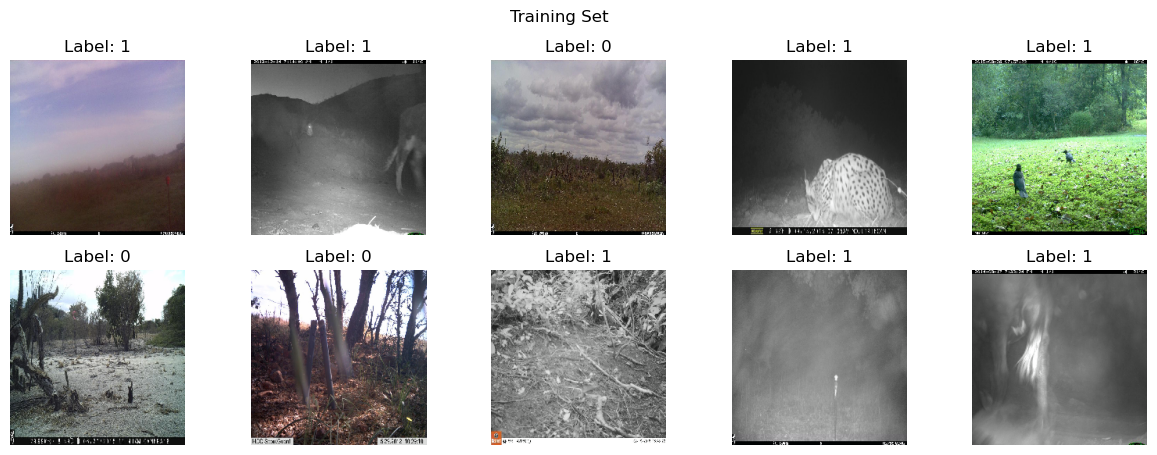

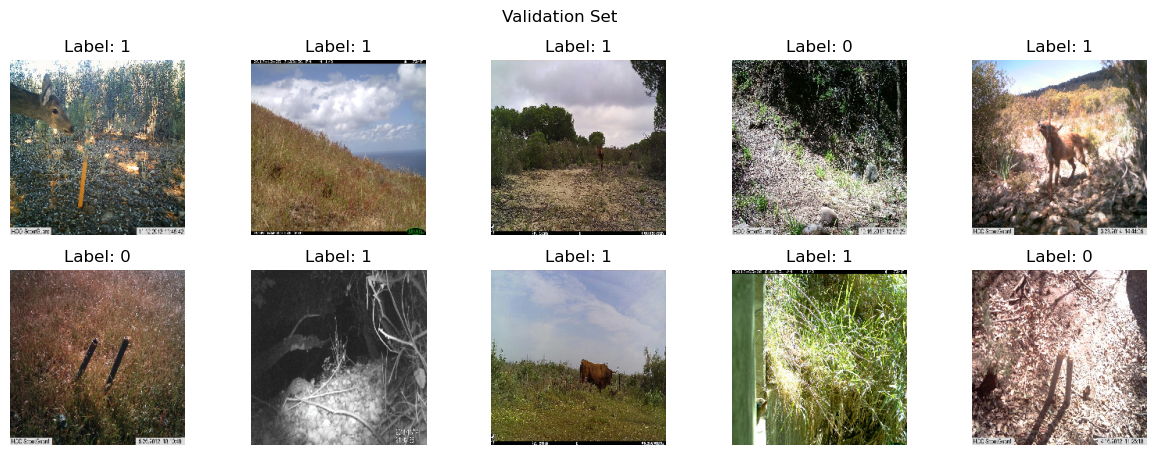

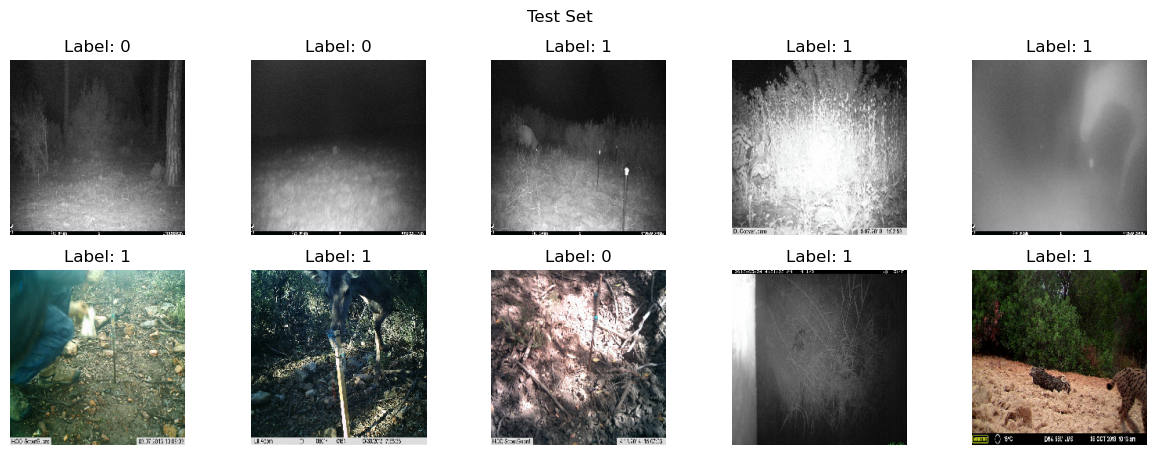

In [8]:
import numpy as np
import matplotlib.pyplot as plt


def show_random_images_from_generator(generator, title):
    # Obtener imágenes y etiquetas del generador
    images, labels = next(generator)

    # Revertir el preprocesamiento de VGG16
    mean = np.array([103.939, 116.779, 123.68])  # Medias de ImageNet
    images = images + mean  # Revertir la normalización por medias
    images = images[..., ::-1]  # Convertir de BGR a RGB
    images = np.clip(images, 0, 255)  # Asegurarse de que los valores estén en [0, 255]

    # Visualizar las imágenes
    plt.figure(figsize=(15, 5))
    for i in range(min(10, len(images))):  # Mostrar un máximo de 10 imágenes
        plt.subplot(2, 5, i + 1)
        plt.imshow(images[i].astype("uint8"))  # Convertir a uint8 para visualización
        plt.title(f"Label: {int(labels[i])}")
        plt.axis("off")
    plt.suptitle(title)
    plt.show()


# Mostrar ejemplos de cada conjunto
show_random_images_from_generator(train_images, "Training Set")
show_random_images_from_generator(validation_images, "Validation Set")
show_random_images_from_generator(test_images, "Test Set")

In [9]:
base_model = tensorflow.keras.applications.VGG16(
    weights="imagenet", include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
)
base_model.trainable = False

# Construir el modelo básico
model = tensorflow.keras.models.Sequential(
    [
        base_model,
        tensorflow.keras.layers.GlobalAveragePooling2D(),
        tensorflow.keras.layers.Dense(1, activation="sigmoid"),
    ],
    name=f"VGG16_v.{VERSION}",
)

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=[
        "accuracy",
        "binary_accuracy",
        Precision(name="presision"),
        Recall(name="recall"),
        AUC(name="auc"),
        TruePositives(name="tp"),
        FalsePositives(name="fp"),
        TrueNegatives(name="tn"),
        FalseNegatives(name="fn"),
    ],
)

model.summary()

2024-12-07 21:24:38.007362: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-12-07 21:24:38.007392: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-12-07 21:24:38.007400: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-12-07 21:24:38.007427: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-07 21:24:38.007441: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "VGG16_v.1.0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1)                 513       
                                                                 
Total params: 14715201 (56.13 MB)
Trainable params: 513 (2.00 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [10]:
history = model.fit(
    train_images,
    validation_data=validation_images,
    epochs=EPOCHS,
    callbacks=[TensorBoard(log_dir=f"./logs/VGG16/v.{VERSION}")],
)

Epoch 1/25


2024-12-07 21:24:39.030719: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


625/625 [==============================] - ETA: 0s - loss: 0.3552 - accuracy: 0.8423 - binary_accuracy: 0.8423 - presision: 0.8804 - recall: 0.8814 - auc: 0.9153 - tp: 11664.0000 - fp: 1584.0000 - tn: 5181.0000 - fn: 1569.0000

2024-12-07 21:29:30.658488: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


625/625 [==============================] - 354s 565ms/step - loss: 0.3552 - accuracy: 0.8423 - binary_accuracy: 0.8423 - presision: 0.8804 - recall: 0.8814 - auc: 0.9153 - tp: 11664.0000 - fp: 1584.0000 - tn: 5181.0000 - fn: 1569.0000 - val_loss: 0.2724 - val_accuracy: 0.8877 - val_binary_accuracy: 0.8877 - val_presision: 0.9073 - val_recall: 0.9249 - val_auc: 0.9502 - val_tp: 2622.0000 - val_fp: 268.0000 - val_tn: 1181.0000 - val_fn: 213.0000
Epoch 2/25
625/625 [==============================] - 354s 566ms/step - loss: 0.2547 - accuracy: 0.8864 - binary_accuracy: 0.8864 - presision: 0.9145 - recall: 0.9139 - auc: 0.9556 - tp: 12093.0000 - fp: 1131.0000 - tn: 5634.0000 - fn: 1140.0000 - val_loss: 0.2404 - val_accuracy: 0.9006 - val_binary_accuracy: 0.9006 - val_presision: 0.9222 - val_recall: 0.9280 - val_auc: 0.9609 - val_tp: 2631.0000 - val_fp: 222.0000 - val_tn: 1227.0000 - val_fn: 204.0000
Epoch 3/25
625/625 [==============================] - 350s 560ms/step - loss: 0.2340 - accura

In [11]:
model.save(f"./models/VGG16/VGG16_v.{VERSION}.h5")

/Users/carlos/miniconda3/envs/TFG/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [12]:
history_df = pd.DataFrame(history.history)
history_df.to_csv(f"./logs/VGG16/v.{VERSION}/train_validation_history.csv", index=False)

In [13]:
results = history.model.evaluate(test_images)

metric_names = history.model.metrics_names
evaluation_results = {
    ("test_" + name): value for name, value in zip(metric_names, results)
}
evaluation_df = pd.DataFrame([evaluation_results])
evaluation_df.to_csv(f"./logs/VGG16/v.{VERSION}/test_history.csv", index=False)


134/134 [==============================] - 58s 433ms/step - loss: 0.2367 - accuracy: 0.8948 - binary_accuracy: 0.8948 - presision: 0.9204 - recall: 0.9207 - auc: 0.9627 - tp: 2612.0000 - fp: 226.0000 - tn: 1225.0000 - fn: 225.0000
